## load casia-webface dataset with 200 class 

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import random
import cv2
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter  # Import Counter at the top
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [4]:
import os
import cv2
import numpy as np

# Function to load the CASIA WebFace dataset without any preprocessing
def load_casia_webface_data(dataset_path, max_classes):
    images = []
    labels = []
    label_map = {}
    current_label = 0

    # Iterate through the directory structure
    for subdir, dirs, _ in os.walk(dataset_path):
        for dir_name in sorted(dirs):
            if dir_name == 'casia-webface':
                print(f"Skipping folder: {dir_name}")
                continue

            if current_label >= max_classes:
                break

            # Define the path for each identity folder
            identity_dir = os.path.join(subdir, dir_name)
            label_map[current_label] = dir_name  # Map the label to the identity

            # print(f"Processing identity: {dir_name} (Label {current_label})")  # Debugging line

            # Iterate through images in each identity folder
            for img_file in os.listdir(identity_dir):
                img_path = os.path.join(identity_dir, img_file)

                # Only process valid image files
                if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                # Debugging: Print path to make sure it's correct
                # print(f"Reading image: {img_path}")

                # Read the image without any preprocessing
                img = cv2.imread(img_path)

                # Check if the image was loaded properly
                if img is None:
                    print(f"Warning: Unable to read image {img_path}")
                    continue

                # Append image and its label
                images.append(img)
                labels.append(current_label)

            current_label += 1

        # Stop if we have reached the maximum number of classes
        if current_label >= max_classes:
            break

    # Check if any images were loaded
    if not images:
        raise ValueError("No images were loaded. Please check the dataset structure and image paths.")

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    print(f"Loaded {images.shape[0]} images.")  # Debugging line
    
    return images, labels, label_map

# Path to the extracted dataset (make sure this path is correct)
dataset_path = 'Desktop/CV/milestone_2'

# Maximum number of classes to use
max_classes = 51

# Load dataset
try:
    images, labels, label_map = load_casia_webface_data(dataset_path, max_classes=max_classes)
    print(f"Loaded {images.shape[0]} images with {len(label_map)} identities.")
    
except ValueError as e:
    print(f"Error: {e}")   

Skipping folder: casia-webface
Loaded 9437 images.
Loaded 9437 images with 51 identities.


## visualize random images with their labels

Total Images: 9437
Total Classes: 51


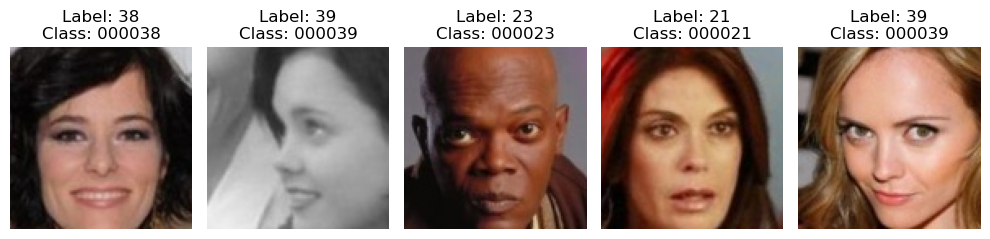

In [6]:
# Function to visualize random images with their labels
def visualize_random_samples(images, labels, label_map, num_samples=5):
    # Select random indices
    random_indices = random.sample(range(len(images)), num_samples)

    # Create a plot
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(images[idx].astype(np.uint8), cv2.COLOR_RGB2BGR))  # Convert BGR to RGB for proper display
        plt.title(f"Label: {labels[idx]}\nClass: {label_map[labels[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Print the number of images and classes
print(f"Total Images: {images.shape[0]}")
print(f"Total Classes: {len(label_map)}")

# Visualize random samples
visualize_random_samples(images, labels, label_map)


## Split dataset

In [8]:

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} images")
print(f"Test set size: {X_test.shape[0]} images")


# Normalize images to [0, 1] range
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0


Training set size: 7549 images
Test set size: 1888 images


In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

# Balance Dataset using SMOTE
X_train_flat = X_train.reshape(len(X_train), -1)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)
X_train_balanced = X_train_balanced.reshape(-1, 112, 112, 3)
print(f"Balanced training set size: {X_train_balanced.shape[0]} images")

Balanced training set size: 23358 images


In [10]:
X_train.shape

(7549, 112, 112, 3)

In [11]:
X_test.shape

(1888, 112, 112, 3)

## Convolutional Autoencoder

In [13]:
# Input layer
input_layer = tf.keras.Input(shape=(112, 112, 3), name='input_layer')

# Encoder: Convolutional layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)  # Batch Normalization

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

# Code layer (Bottleneck)
code_layer = tf.keras.layers.MaxPooling2D((2, 2), name='code_layer')(x)

# Decoder: Transposed convolutional layers (for upsampling)
x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(code_layer)
x = tf.keras.layers.UpSampling2D((2, 2))(x)  # (14, 14, 128)

x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)  # (28, 28, 64)

x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)  # (56, 56, 32)

# Final upsampling to get back to (112, 112, 3)
x = tf.keras.layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)  # (112, 112, 16)

# Final layer to match input shape (112, 112, 3)
output_layer = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output_layer')(x)


## train dataset 

In [15]:
casia_AE=tf.keras.Model(input_layer , output_layer)
casia_AE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
casia_AE.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ code_layer (MaxPooling2D)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 56, 56, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv2D)           │ (None, 112, 112, 3)    │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,043 (1.29 MB)

 Trainable params: 338,595 (1.29 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
history=casia_AE.fit(X_train_balanced, X_train_balanced , epochs=10,validation_split=0.2)

Epoch 1/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 92s 149ms/step - accuracy: 0.8699 - loss: 0.0104 - val_accuracy: 0.9195 - val_loss: 0.0043
Epoch 2/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 86s 147ms/step - accuracy: 0.8967 - loss: 0.0048 - val_accuracy: 0.9115 - val_loss: 0.0035
Epoch 3/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 88s 150ms/step - accuracy: 0.8991 - loss: 0.0040 - val_accuracy: 0.9255 - val_loss: 0.0026
Epoch 4/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 86s 147ms/step - accuracy: 0.9000 - loss: 0.0035 - val_accuracy: 0.9183 - val_loss: 0.0027
Epoch 5/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 85s 145ms/step - accuracy: 0.8995 - loss: 0.0032 - val_accuracy: 0.9141 - val_loss: 0.0025
Epoch 6/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 84s 144ms/step - accuracy: 0.9040 - loss: 0.0032 - val_accuracy: 0.9226 - val_loss: 0.0023
Epoch 7/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 83s 142ms/step - accuracy: 0.9097 - loss: 0.0028 - val_accuracy: 0.9239 - val_loss: 0.0027
Epoch 8/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 83s 143ms/step - accuracy: 0.9103 - loss: 0

In [17]:
# Evaluate the model on the training data
training_loss, training_accuracy = casia_AE.evaluate(X_test, X_test)

# Print the results
print(f' Data Loss: {round(float(training_loss), 4)}')
print(f' Data Accuracy: {round(float(training_accuracy), 2)}')


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9017 - loss: 0.0029
 Data Loss: 0.003
 Data Accuracy: 0.9


In [18]:
casia_AE.save("casia_AE.keras")

## Retrain the model with input and code lyer only 

In [20]:
get_encoded = tf.keras.Model(inputs=casia_AE.input, outputs=casia_AE.get_layer("code_layer").output)

In [21]:
encoded = get_encoded.predict(X_test)
print(encoded.shape)  # Let's assume the output shape is (1888, 7, 7, 8)

# Calculate correct reshape dimensions
correct_dim1 = 7 * 7 * 128 

# Reshape the array
encoded = encoded.reshape((len(X_test), correct_dim1)) 
print(encoded.shape)  # Should print (1888, 392)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
(1888, 7, 7, 128)
(1888, 6272)


## Extract encoded features using the trained autoencoder

In [23]:
# Get the encoded features from the autoencoder (latent space)
encoded_train = get_encoded.predict(X_train_balanced)
encoded_test = get_encoded.predict(X_test)

# Reshape the encoded features to 2D array (samples, features) for SVM
encoded_train = encoded_train.reshape((len(X_train_balanced), -1))  # Flatten the encoded features
encoded_test = encoded_test.reshape((len(X_test), -1))    # Flatten the encoded features


730/730 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [27]:
reconstructed_casia = casia_AE.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


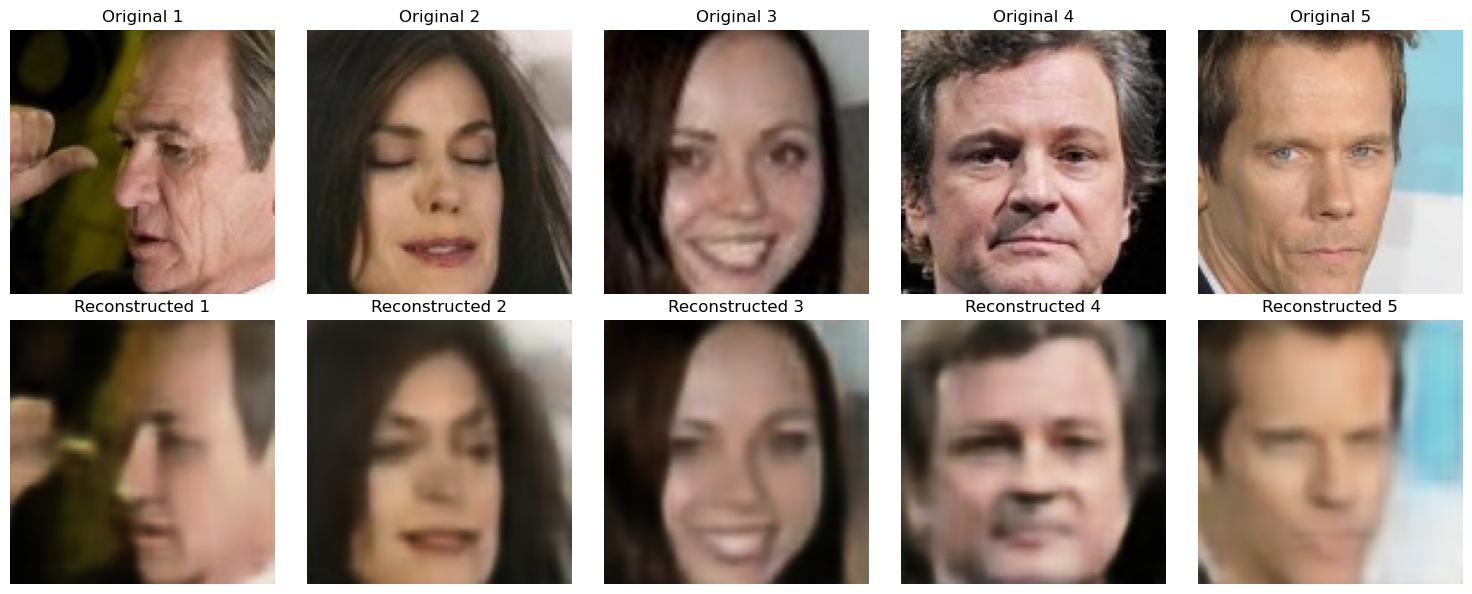

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_original_and_reconstructed(original_images, reconstructed_images, num_samples=5):
    # Select random indices
    random_indices = np.random.randint(0, len(original_images), num_samples)

    # Create a plot
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i, idx in enumerate(random_indices):
        # Original image
        original_image = original_images[idx]

        # Reconstructed image
        reconstructed_image = reconstructed_images[idx]

        # Ensure original image is in the range [0, 255] for display
        if original_image.max() <= 1:  # If normalized to [0, 1], convert to [0, 255]
            original_image = (original_image * 255).astype(np.uint8)

        # Ensure reconstructed image is in the range [0, 255] for display
        if reconstructed_image.max() <= 1:  # If normalized to [0, 1], convert to [0, 255]
            reconstructed_image = (reconstructed_image * 255).astype(np.uint8)

        # Display the original image in the first row
        axes[0, i].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for proper display
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        # Display the reconstructed image in the second row
        axes[1, i].imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for proper display
        axes[1, i].set_title(f"Reconstructed {i+1}")
        axes[1, i].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Assuming that `reconstructed_casia` is the output of your autoencoder
# Ensure that `original_images` and `reconstructed_images` are properly formatted before visualization
visualize_original_and_reconstructed(X_test, reconstructed_casia, num_samples=5)


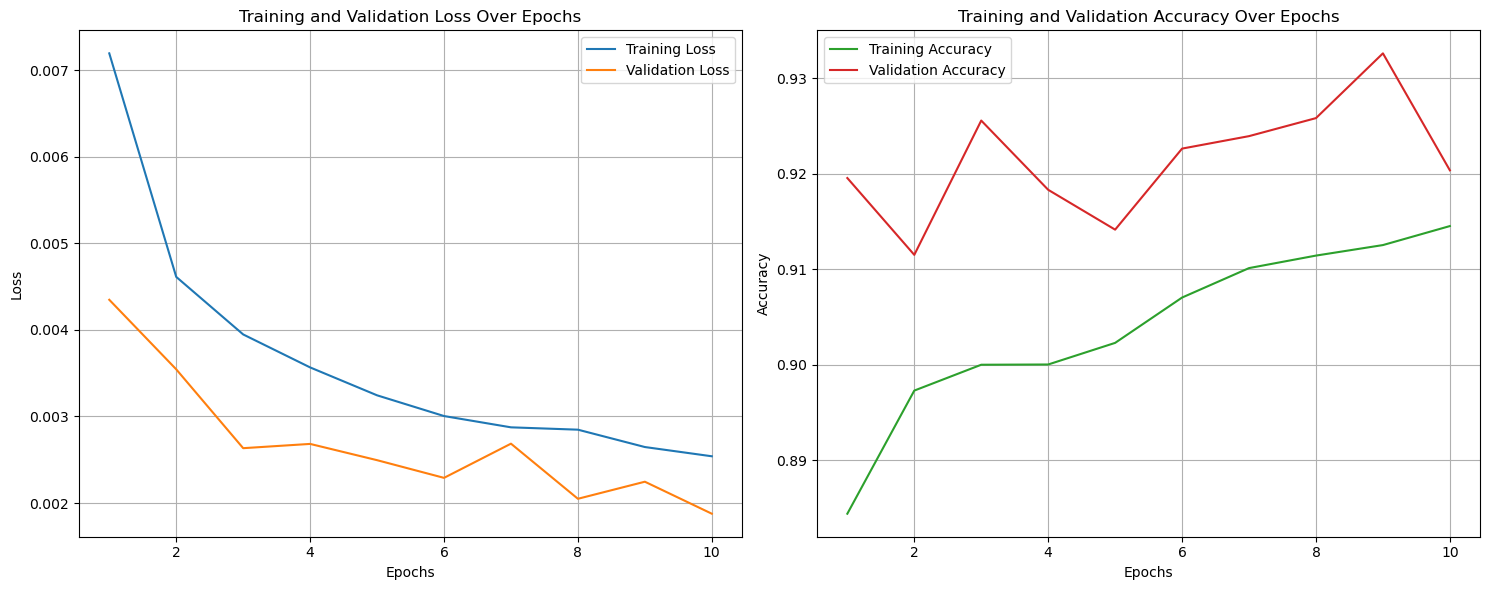

In [31]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a figure with two subplots (one for loss and one for accuracy)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting training and validation loss on the first subplot (ax1)
ax1.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='tab:blue')
ax1.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Over Epochs')
ax1.legend()
ax1.grid()

# Plotting training and validation accuracy on the second subplot (ax2)
ax2.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='tab:green')
ax2.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', color='tab:red')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Over Epochs')
ax2.legend()
ax2.grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Train the SVM classifier

In [33]:
# Standardize the features (important for SVM)
scaler = StandardScaler()
encoded_train = scaler.fit_transform(encoded_train)
encoded_test = scaler.transform(encoded_test)

# Initialize and train the SVM classifier
svm_classifier = SVC(kernel='linear',C=10)  # You can also try 'rbf' or other kernels
svm_classifier.fit(encoded_train, y_train_balanced)  # Train on the encoded features and the corresponding labels

# Predict on the test set
y_pred = svm_classifier.predict(encoded_test)


## Evaluate the model's accuracy

In [35]:
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Classifier Accuracy: {accuracy * 100:.2f}%")

SVM Classifier Accuracy: 72.35%


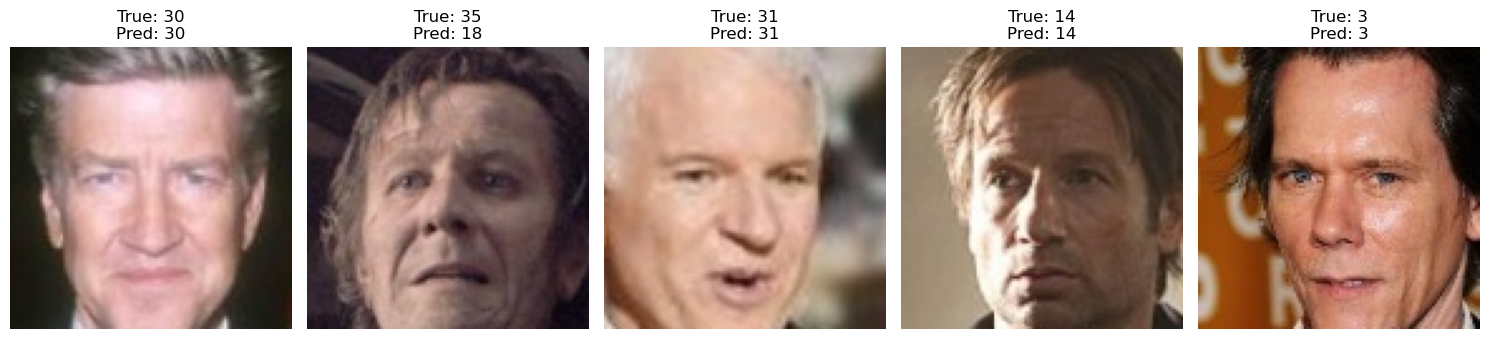

In [36]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = np.random.randint(0, len(X_test), num_samples)

# Create a figure for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

# Ensure axes is iterable even if there's only one axis
if num_samples == 1:
    axes = [axes]

for i, idx in enumerate(random_indices):
    # Get the test image and its true label
    test_image = X_test[idx]
    true_label = y_test[idx]
    
    # If the image is normalized (values between 0 and 1), rescale it to [0, 255]
    if test_image.max() <= 1:  # Check if it's normalized (between 0 and 1)
        test_image = (test_image * 255).astype(np.uint8)  # Convert to 0-255 range

    # Ensure the image values are in the valid range [0, 255] for display
    test_image = np.clip(test_image, 0, 255)

    # Convert BGR to RGB if necessary (assuming images might be in BGR format)
    if len(test_image.shape) == 3 and test_image.shape[2] == 3:  # RGB or BGR image
        test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for proper visualization

    # Get the predicted label using the classifier
    predicted_label = svm_classifier.predict([encoded_test[idx]])[0]
    
    # Display the image
    if len(test_image.shape) == 2:  # Grayscale image
        axes[i].imshow(test_image, cmap='gray')
    else:  # RGB image
        axes[i].imshow(test_image)

    # Display the true and predicted labels as titles
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')  # Hide axes for better visualization

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


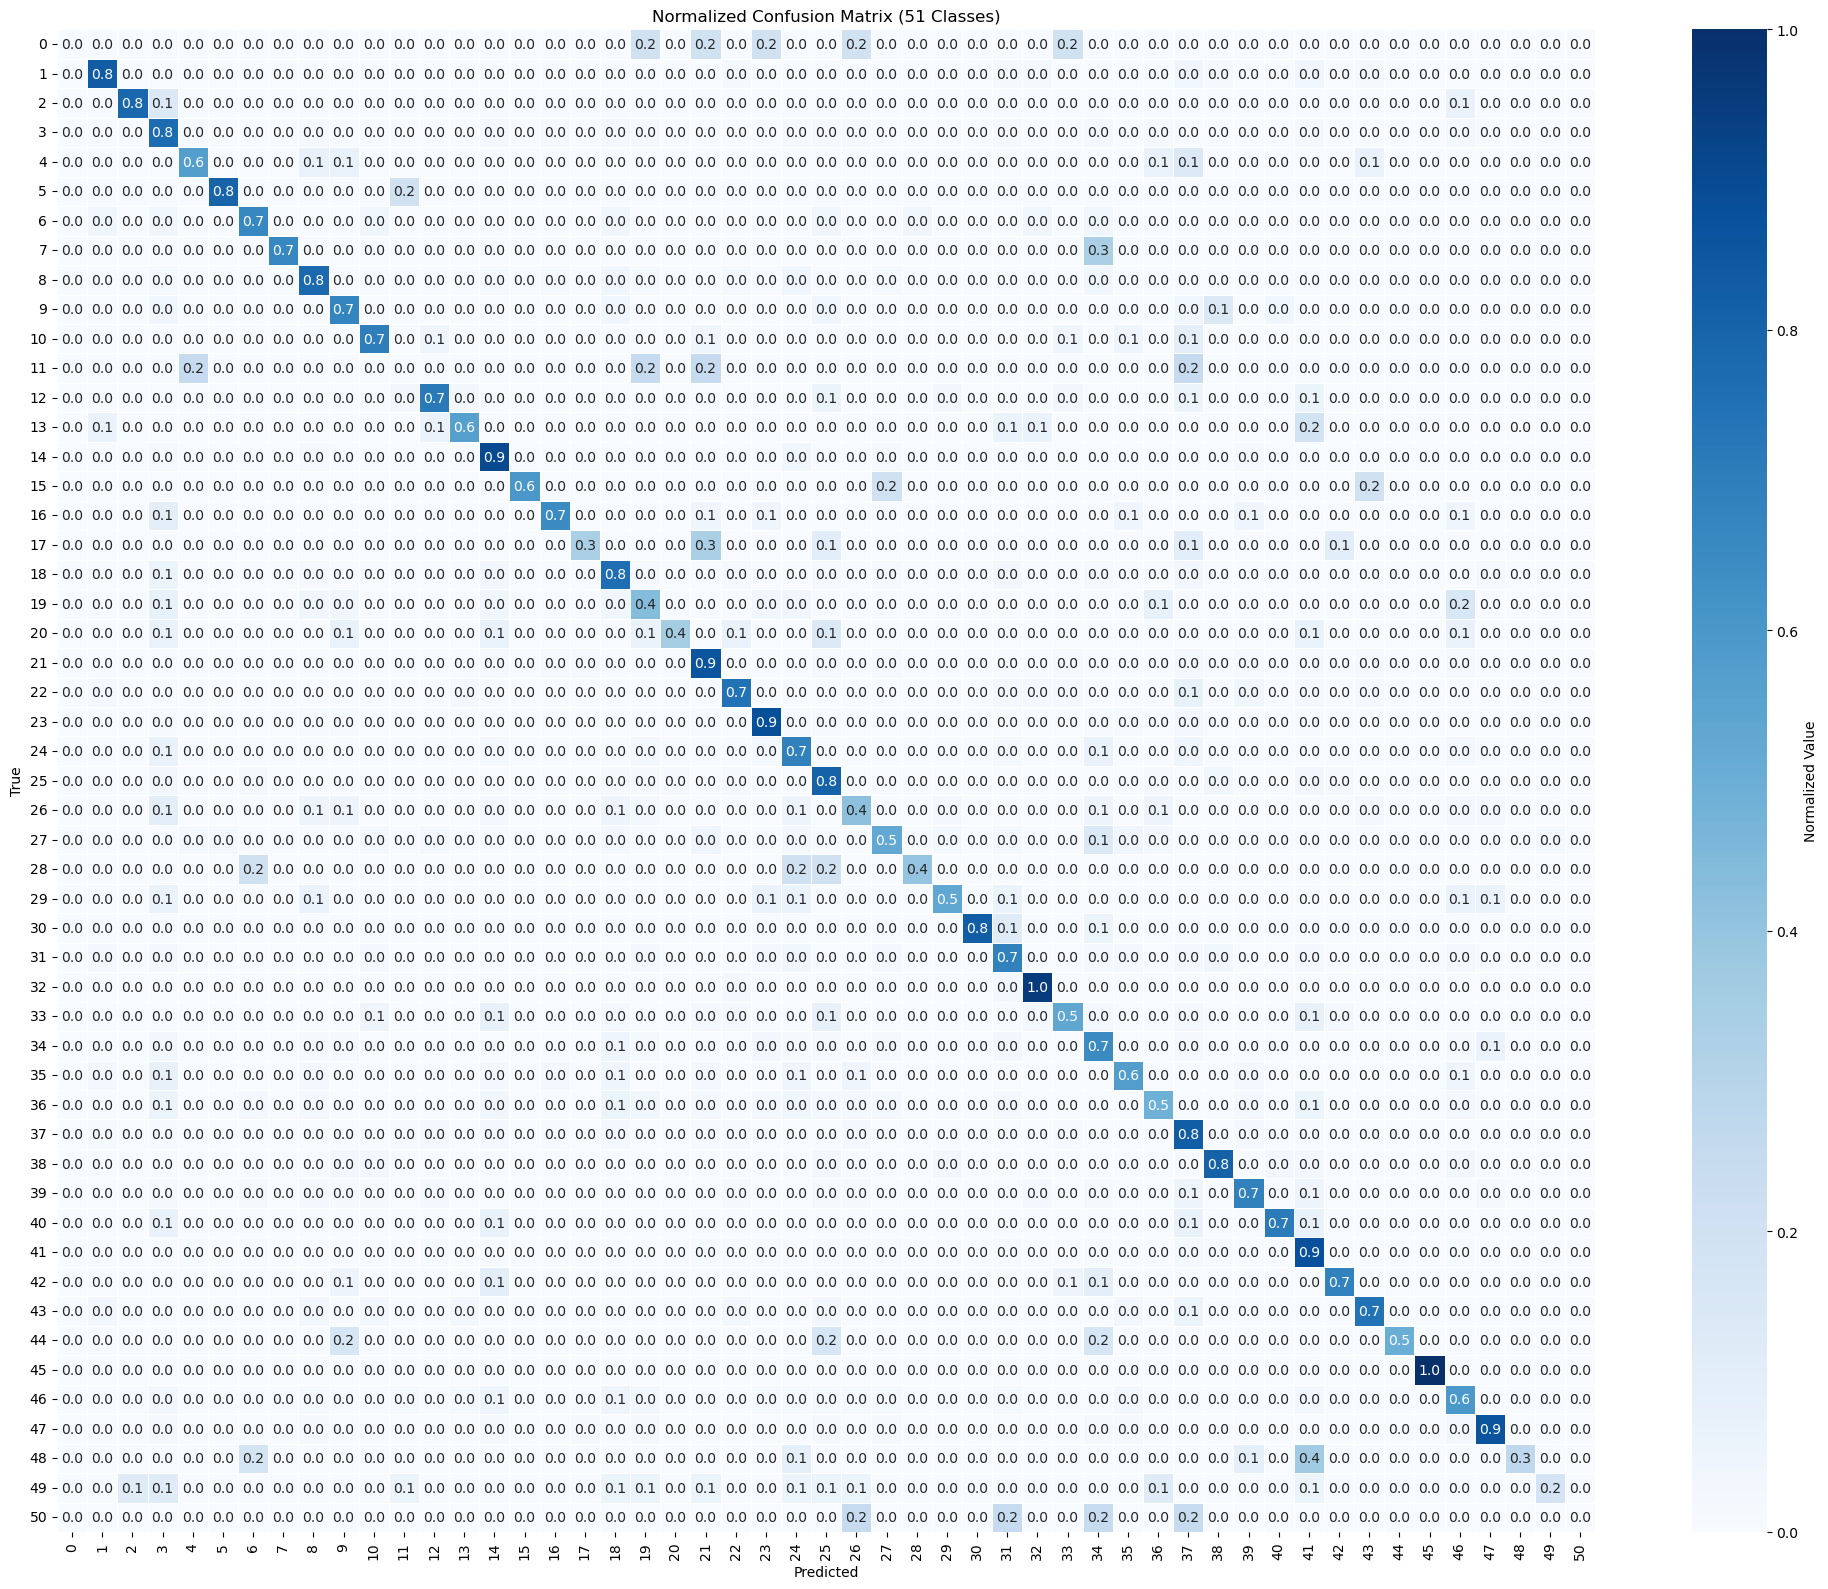

In [37]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(20, 16))  # Increase figure size for better visibility
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), 
            cbar_kws={'label': 'Normalized Value'}, linewidths=0.5)

# Rotate the labels to prevent overlapping
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (51 Classes)')

# Adjust layout for better readability
plt.tight_layout()
plt.show()
